In [1]:
from fenics import *
import numpy as np

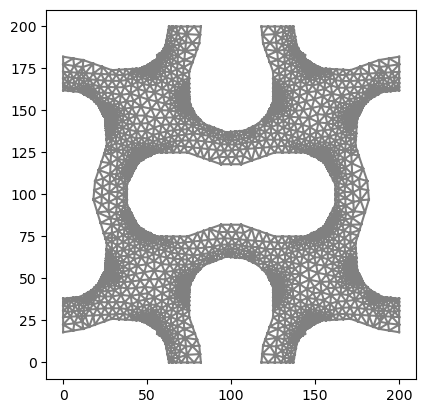

In [2]:
import os;
import matplotlib.pyplot as plt
path = './'
mesh = Mesh(path + 'test.xml');
plot(mesh)
materials = MeshFunction('size_t', mesh, mesh.topology().dim(), mesh.domains())

In [3]:
class ElasticityParameter(UserExpression):
    def __init__(self, materials, E1, E2, nu, alpha1, alpha2, parameter_type, **kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.E1 = E1
        self.E2 = E2
        self.nu = nu
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.parameter_type = parameter_type

    def eval_cell(self, values, x, cell):
        material_type = self.materials[cell.index]
        if self.parameter_type == 'mu':
            E = self.E1 if material_type == 1 else self.E2
            values[0] = E / (2 * (1 + self.nu))
        elif self.parameter_type == 'lambda':
            E = self.E1 if material_type == 1 else self.E2
            values[0] = E * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
        elif self.parameter_type == 'alpha':
            values[0] = self.alpha1 if material_type == 1 else self.alpha2
        else:
            raise ValueError("Invalid parameter type. Choose 'mu', 'lambda', or 'alpha'.")

    def value_shape(self):
        return ()

# Usage



In [4]:
# Define function space
V = VectorFunctionSpace(mesh, 'P', 1)
# Define the variational problem
u = TrialFunction(V)
v = TestFunction(V)
# Elasticity parameters
E1, E2, nu = 10e9, 20e9, 0.3  # example values
alpha1,alpha2 = 1.,10
mu = ElasticityParameter(materials, E1, E2, nu, alpha1, alpha2, 'mu', degree=0)
lambda_ = ElasticityParameter(materials, E1, E2, nu, alpha1, alpha2, 'lambda', degree=0)
alpha = ElasticityParameter(materials, E1, E2, nu, alpha1, alpha2, 'alpha', degree=0)


In [5]:
def eps(v):
    return sym(grad(v))
def sigma(v):
    return lambda_*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

In [6]:
f = Constant((1e-3, 0))

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx

In [7]:
def left(x, on_boundary):
    return near(x[0], 0.)

bc = DirichletBC(V, Constant((0.,0.)), left)

u = Function(V, name="Displacement")
solve(a == l, u, bc)



Solving linear variational problem.


Object cannot be plotted directly, projecting to piecewise linears.


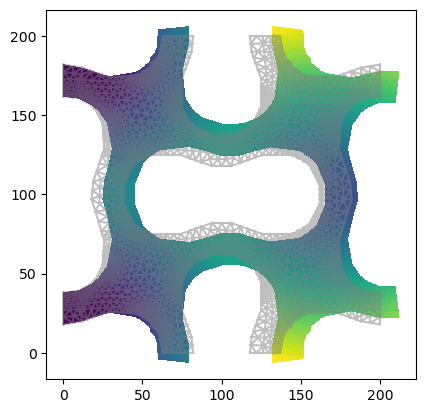

In [8]:
plot(1.e9*u, mode="displacement")
plot(mesh,alpha=0.5)